In [5]:
import time
import matplotlib.pyplot as plt

from sast.utils import *
from sast.sast import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from sktime.datasets import load_UCR_UEA_dataset


In [2]:
lab = False # True if I am on my lab computer
#ds_folder = '/home/mimbouop/ucr_dataset' if lab else '/home/michael/Projects/USTC/dataset/Shapelet_ucr'
ds_folder = r'C:\Users\Nicolas R\Documents\random_sast'
ds_name = 'Chinatown'
random_state = None

# Loading the dataset

In [33]:
ds='Chinatown' # Chosing a dataset from # Number of classes to consider
X_train, y_train = load_UCR_UEA_dataset(name=ds, extract_path='data', split="train", return_type="numpy2d")
X_test, y_test = load_UCR_UEA_dataset(name=ds, extract_path='data', split="test", return_type="numpy2d")


#train_ds, test_ds = load_dataset(ds_folder, ds_name)

#X_train, y_train = format_dataset(train_ds, shuffle=True)
#X_test, y_test = format_dataset(test_ds)

#print(train_ds, y_train, end='\n\n')

train_ds=pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], ignore_index=True)
test_ds=pd.concat([pd.DataFrame(X_test), pd.Series(y_test)], ignore_index=True)




In [34]:
print(test_ds, y_test)

        0      1      2      3      4      5     6      7      8      9   ...  \
0    501.0  328.0  195.0  218.0   67.0   17.0  28.0   72.0  132.0  215.0  ...   
1    880.0  752.0  913.0  863.0  402.0  112.0  60.0  112.0  119.0  186.0  ...   
2    493.0  389.0  174.0  121.0   82.0   36.0  27.0   64.0  127.0  203.0  ...   
3    616.0  323.0  162.0  166.0   68.0   26.0  34.0   68.0  123.0  263.0  ...   
4    389.0  276.0  161.0  124.0   35.0   26.0  51.0   75.0   71.0  126.0  ...   
..     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...  ...   
681      2    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   
682      2    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   
683      2    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   
684      2    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   
685      2    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN  ...   

         14      15      16

## Plot some train instances

In [35]:
classes = np.unique(y_train)
count_per_classes = 1 # Number of instances to plot per each class
max_class_to_plot = min(3, len(classes)) # Number of classes to consider

shape train DS: (40, 24)
classes: ['1' '2'] count_per_classes= 1 max_class_to_plot= 2
i= 0 c= 1
y_train==c: [0 1 2 3 4 5 6 7 8 9]
ts_indices: [8 7]
idx= 8
i= 1 c= 2
y_train==c: [10 11 12 13 14 15 16 17 18 19]
ts_indices: [19 12]
idx= 19
12


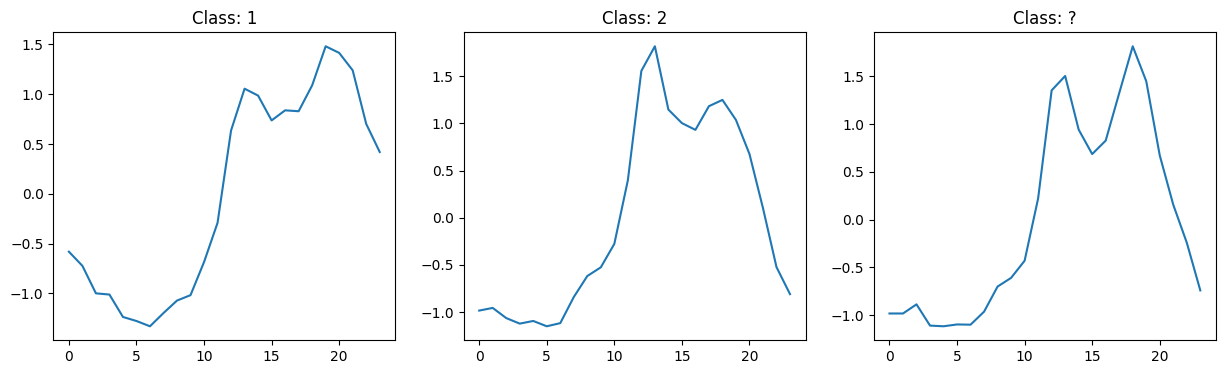

In [36]:
print("shape train DS:", train_ds.shape)
print("classes:",classes,"count_per_classes=", count_per_classes,"max_class_to_plot=", max_class_to_plot)
plt.figure(figsize=(15, 4))

for i, c in enumerate(classes[:max_class_to_plot]):
    print ("i=",i,"c=",c)
    print ("y_train==c:",np.where(y_train==c)[0])
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    print ("ts_indices:",ts_indices)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        print("idx=",idx)
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
print(ts_indices[-1])
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-one-instance-classification.jpg')



shape train DS: (40, 24)
classes: ['1' '2'] count_per_classes= 4 max_class_to_plot= 2
i= 0 c= 1
y_train==c: [0 1 2 3 4 5 6 7 8 9]
ts_indices: [7 2 1 0 6]
idx= 7
idx= 2
idx= 1
idx= 0
i= 1 c= 2
y_train==c: [10 11 12 13 14 15 16 17 18 19]
ts_indices: [16 11 19 13 10]
idx= 16
idx= 11
idx= 19
idx= 13
10


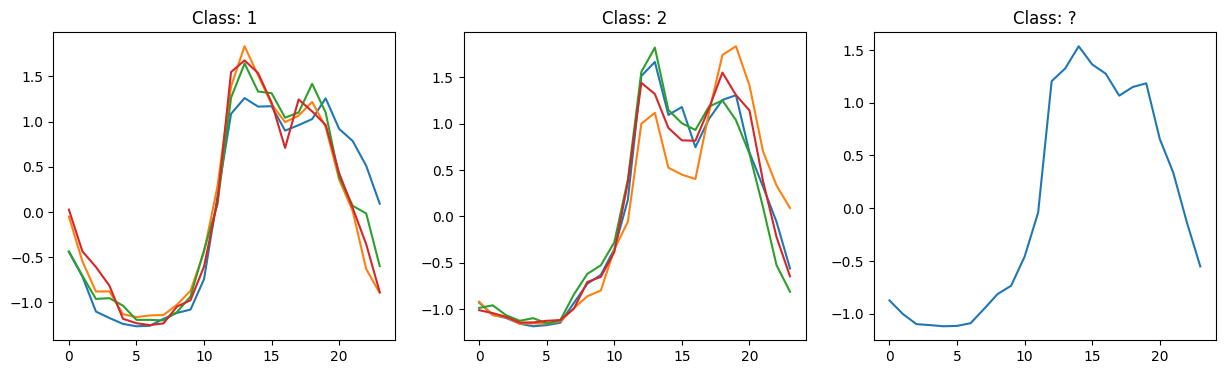

In [37]:
count_per_classes = 4 # Number of instances to plot per each class


print("shape train DS:", train_ds.shape)
print("classes:",classes,"count_per_classes=", count_per_classes,"max_class_to_plot=", max_class_to_plot)
plt.figure(figsize=(15, 4))

for i, c in enumerate(classes[:max_class_to_plot]):
    print ("i=",i,"c=",c)
    print ("y_train==c:",np.where(y_train==c)[0])
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    print ("ts_indices:",ts_indices)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        print("idx=",idx)
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
print(ts_indices[-1])
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-multi-instance-classification.jpg')

# The SAST model

In [38]:
min_shp_length = 3
max_shp_length = X_train.shape[1]
print("shape X_train DS:", X_train.shape)
candidate_lengths = np.arange(min_shp_length, max_shp_length+1)
# candidate_lengths = (3, 7, 9, 11)
nb_inst_per_class = 1
print('candidate_lengths:',candidate_lengths)

shape X_train DS: (20, 24)
candidate_lengths: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## SAST with RidgeClassifier

In [39]:
start = time.time()

ridge = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
#print("np.logspace(-3, 3, 10): ",np.logspace(-3, 3, 10))

sast_ridge = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state= random_state, classifier=ridge)
sast_ridge.fit(X_train, y_train)

print('score:', sast_ridge.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.9620991253644315
duration: 3.251248836517334


c: 1  ts: [[ 448.  344.  183.  146.   71.   14.   30.   41.  108.  137.  277.  576.
  1010. 1271. 1264. 1062. 1093. 1030. 1069. 1151.  898.  754.  467.  362.]]


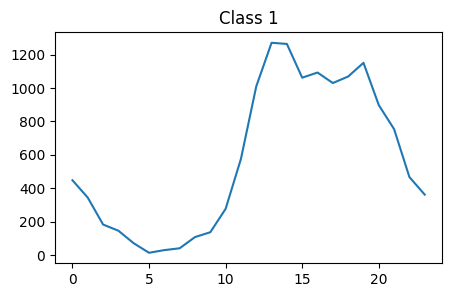

c: 2  ts: [[  78.   60.   51.   17.   10.   12.   22.   73.  172.  186.  318.  414.
  1003. 1153.  981.  846.  872. 1051. 1200. 1276. 1004.  841.  525.  315.]]


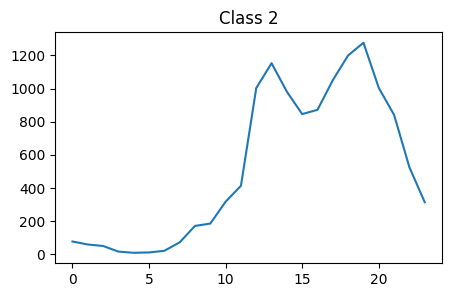

In [40]:
plot_kernel_generators(sast_ridge)

## Let's plot the top most important features over the generators

1 (1, 24)


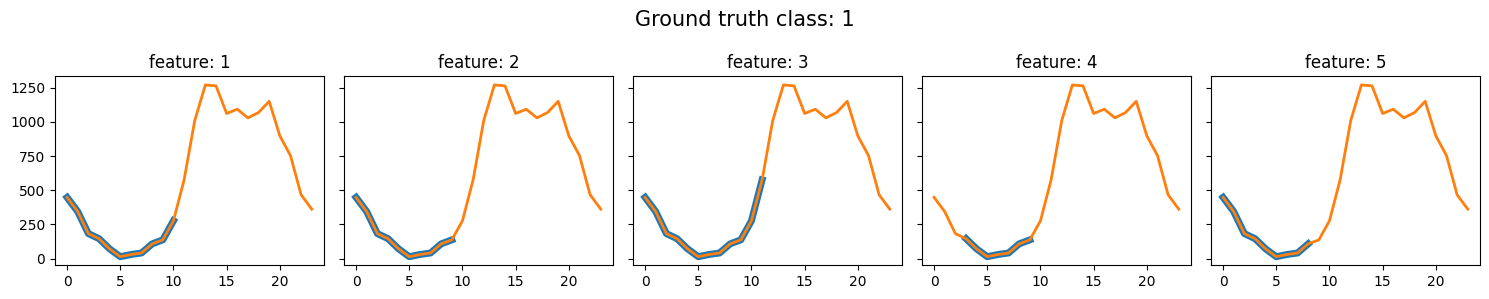

2 (1, 24)


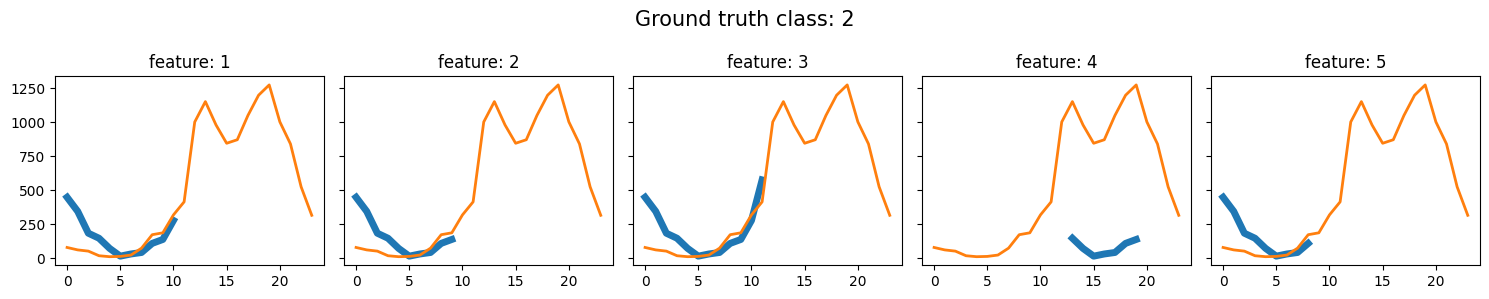

In [41]:
for c, ts in sast_ridge.kernels_generators_.items():
    fname = f'images/chinatown-ridge-class{c}-top5-features-on-ref-ts.jpg'
    print(c,ts.shape )
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=0, fname=fname) # plot only the first model one-vs-all model's features

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=5)

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=10)

## Let's plot the top best features on some test instances

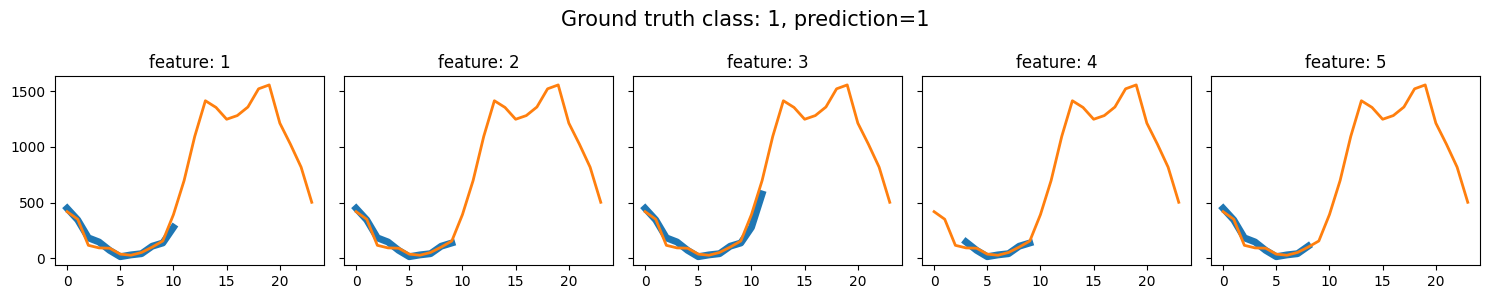

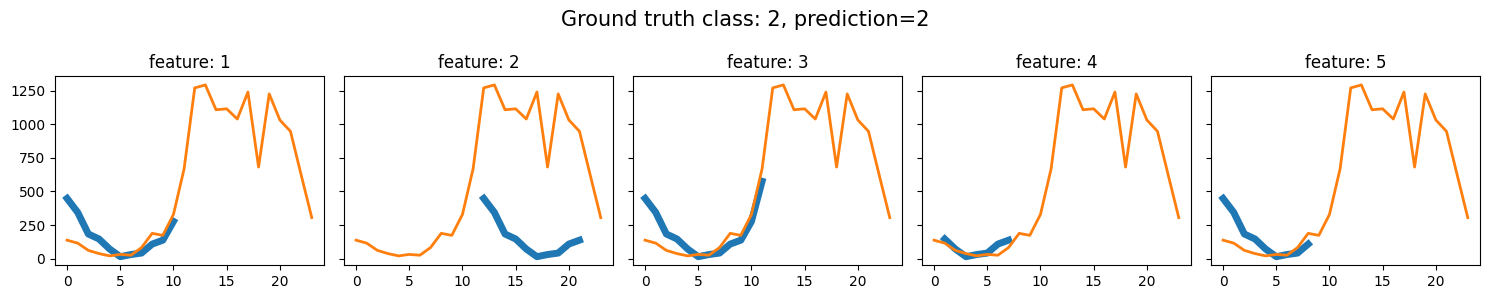

In [42]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_ridge.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-ridge-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], fname=fname) # plot only the first model one-vs-all model's features

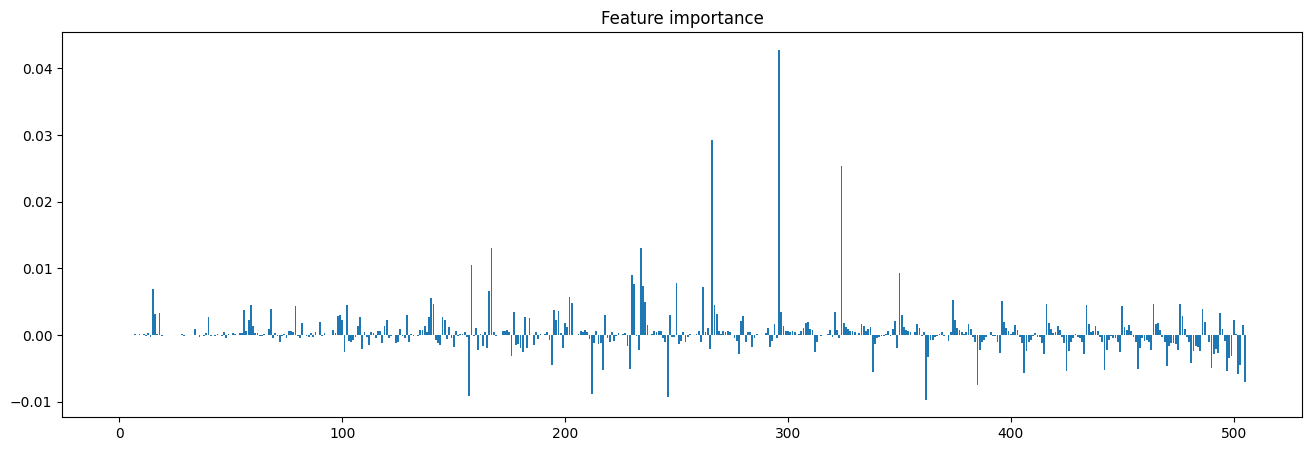

506


<Figure size 640x480 with 0 Axes>

In [43]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_ridge.classifier.coef_[0].size)], sast_ridge.classifier.coef_[0]) # plot only the first model one-vs-all model's features
plt.show()
plt.savefig('images/chinatown-ridge-features-importance.jpg')
print(sast_ridge.classifier.coef_[0].size)

## SAST with RandomForest

In [44]:
start = time.time()

rf = RandomForestClassifier(max_features=None, min_impurity_decrease=0.05)

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=rf)
sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.9708454810495627
duration: 1.1594510078430176


## Let's plot the top most important features overs the generators

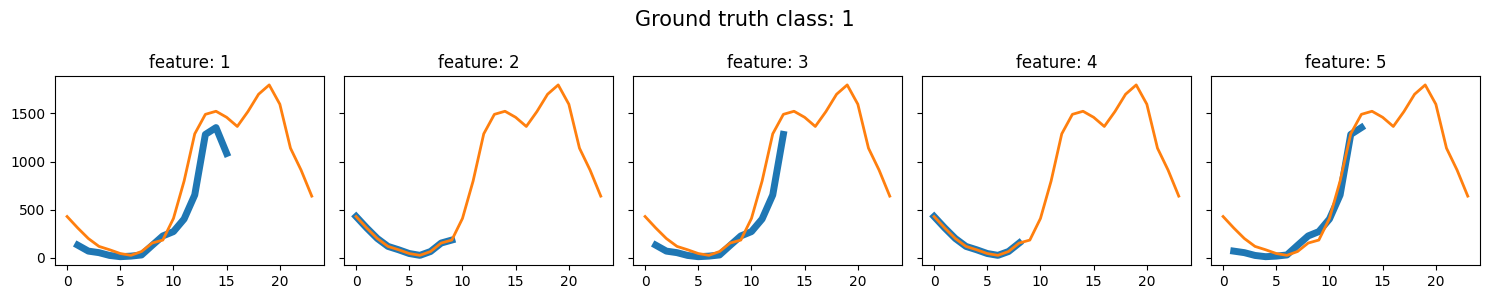

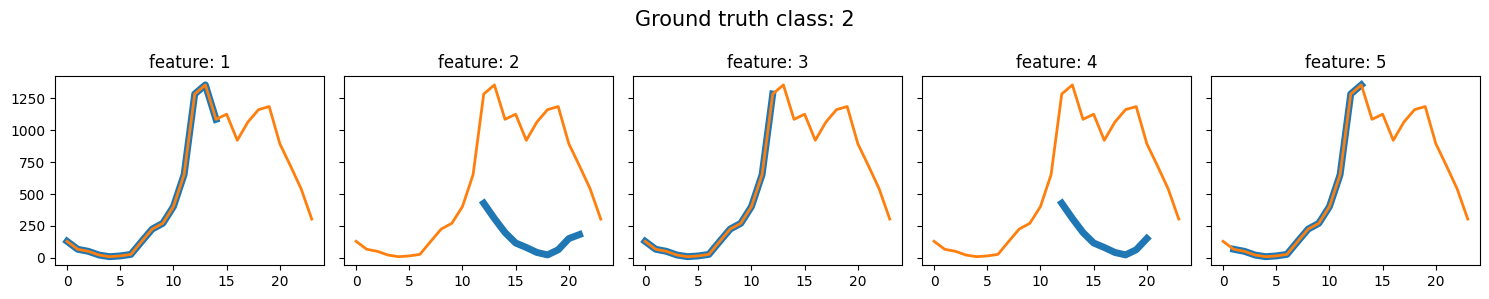

In [45]:
for c, ts in sast_rf.kernels_generators_.items():
    fname = f'images/chinatown-rf-class{c}-top5-features-on-ref-ts.jpg'
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

## Plotting the top best features on some test instances

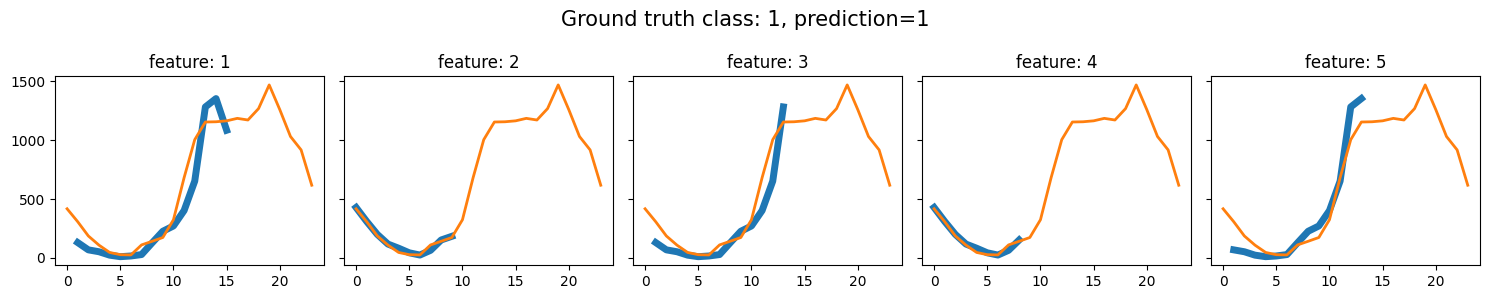

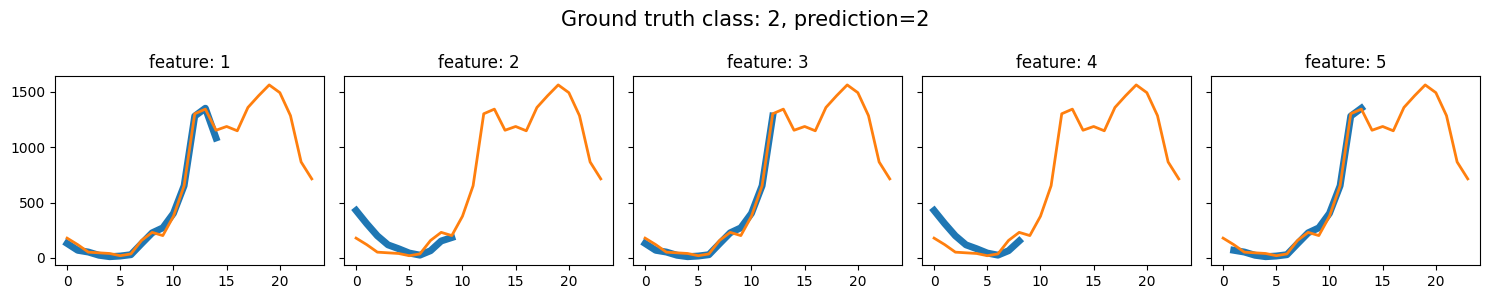

In [46]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_rf.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-rf-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

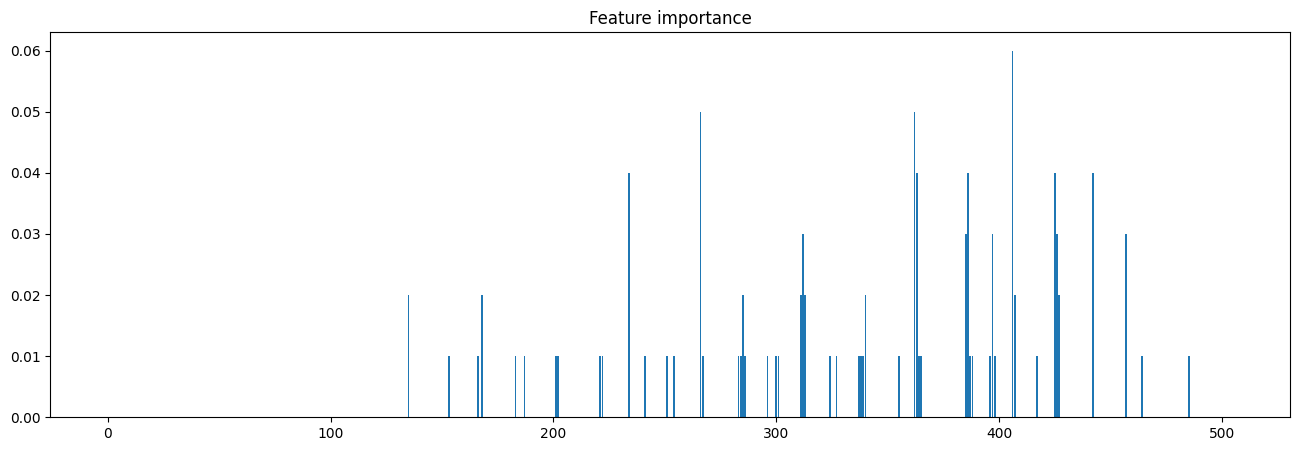

<Figure size 640x480 with 0 Axes>

In [47]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_rf.classifier.feature_importances_.size)], sast_rf.classifier.feature_importances_)
plt.show()
plt.savefig('images/chinatown-rf-features-importance.jpg')

# Ensemble of weak SAST   

A weak SAST model is a SAST model that uses fixed length subsequences. It is faster dans a regular SAST model, could be less accurate

In [48]:
candidate_lengths = (3, 5, 7)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf)

start = time.time()

sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.7900874635568513
duration: 0.3277597427368164


In [49]:
candidate_length_list = [list(range(3, 10)), list(range(10, 17)), list(range(17, 24))]
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf = RandomForestClassifier(min_impurity_decrease=0.05, max_features=None)
saste = SASTEnsemble(cand_length_list=candidate_length_list,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf, n_jobs = -1)

start = time.time()

saste.fit(X_train, y_train)

print('Score:', saste.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

/home/nirojasvar/anaconda3/envs/rsast/lib/python3.10/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(
/home/nirojasvar/anaconda3/envs/rsast/lib/python3.10/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(
/home/nirojasvar/anaconda3/envs/rsast/lib/python3.10/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


Score: 0.9795918367346939
duration: 5.665644407272339


### GridSearch of weights

In [50]:
candidate_length_list

[[3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22, 23]]

In [51]:
from itertools import combinations

weights = np.linspace(0, 1, len(candidate_length_list))
weights

array([0. , 0.5, 1. ])

In [52]:
from sklearn.model_selection import GridSearchCV

#params = {'weights': [(0.5, 0.5), (0.3, 0.7), (0.7, 0.3)]}
params = {'weights': [ (0.3, 0.6,0.1), (0.5, 0.3,0.2),(0.5, 0.5, 0.0)]}
saste_grid = GridSearchCV(estimator=saste, param_grid=params, cv=4, n_jobs = -1)

start = time.time()

saste_grid.fit(X_train, y_train)

print('Score:', saste_grid.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

saste_grid.set_params

/home/nirojasvar/anaconda3/envs/rsast/lib/python3.10/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


Score: 0.9650145772594753
duration: 6.255378246307373


<bound method BaseEstimator.set_params of GridSearchCV(cv=4,
             estimator=SASTEnsemble(cand_length_list=[[3, 4, 5, 6, 7, 8, 9],
                                                      [10, 11, 12, 13, 14, 15,
                                                       16],
                                                      [17, 18, 19, 20, 21, 22,
                                                       23]],
                                    classifier=RandomForestClassifier(max_features=None,
                                                                      min_impurity_decrease=0.05),
                                    n_jobs=-1),
             n_jobs=-1,
             param_grid={'weights': [(0.3, 0.6, 0.1), (0.5, 0.3, 0.2),
                                     (0.5, 0.5, 0.0)]})>

# Using Shapelet Transform

In [53]:
#from sktime.utils.data_container import detabularise
#from sktime.transformers.series_as_features.shapelets import ShapeletTransform
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested


In [54]:
def plot_shapelets(st, X_train, y_train, nb_shapelet = np.inf, offset = 0, fname=None):
    shapelet_per_time_series = {}
    max_ = min(len(st.shapelets), nb_shapelet)
    for i in range(offset, max_ + offset):
        s = st.shapelets[i]
        # summary info about the shapelet
        print("#"+str(i)+": "+str(s))
        if s.series_id in shapelet_per_time_series:
            shapelet_per_time_series[s.series_id].append(s)
        else:
            shapelet_per_time_series[s.series_id] = [s,]
    
    max_ = len(shapelet_per_time_series)
    fig, axes = plt.subplots(1, max_, figsize= (3*max_, 3), tight_layout=True)
    for i, ts_id in enumerate(shapelet_per_time_series.keys()):
        ts_normalized = znormalize_array(X_train.iloc[ts_id,0].values)
        for j, s in enumerate(shapelet_per_time_series[ts_id]):
            # overlay shapelets
            axes[i].plot(
                list(range(s.start_pos,(s.start_pos+s.length))),
                ts_normalized[s.start_pos:s.start_pos+s.length],
                linewidth=5
            )
        axes[i].plot(ts_normalized)
        axes[i].set_title(f'Time series: {ts_id}, class: {y_train[ts_id]}')
    if fname is not None:
        plt.savefig(fname=fname)
    plt.show()

In [55]:
# convert our dataset to sktime format
X_train_sktime = from_2d_array_to_nested(pd.DataFrame(X_train))
X_test_sktime = from_2d_array_to_nested(pd.DataFrame(X_test))
print(X_train.shape)
print(X_train_sktime.shape)

(20, 24)
(20, 1)


## ST

In [56]:
start = time.time()

st = ShapeletTransform(min_shapelet_length=min_shp_length, max_shapelet_length=np.inf)
st.fit(X_train_sktime, y_train)

X_train_transformed = st.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = st.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test)) # Score: 0.9737609329446064 on Chinatown
print('Duration:', end - start)

Score: 0.9737609329446064
Duration: 58.202953577041626


#0: Series ID: 5, start_pos: 0, length: 11, info_gain: 0.9980008838722996, 
#1: Series ID: 2, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#2: Series ID: 4, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#3: Series ID: 3, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#4: Series ID: 0, start_pos: 8, length: 6, info_gain: 0.9980008838722996, 


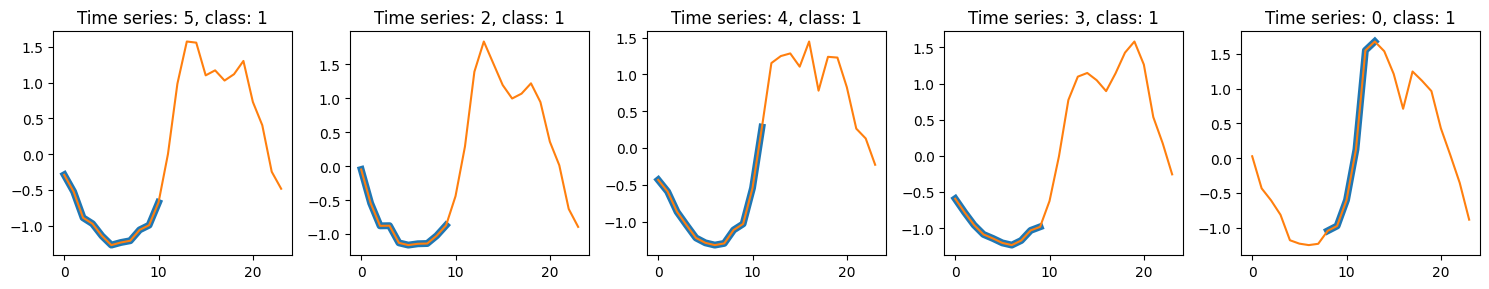

#5: Series ID: 6, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#6: Series ID: 1, start_pos: 3, length: 9, info_gain: 0.9980008838722996, 
#7: Series ID: 9, start_pos: 1, length: 11, info_gain: 0.9980008838722996, 
#8: Series ID: 8, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#9: Series ID: 7, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 


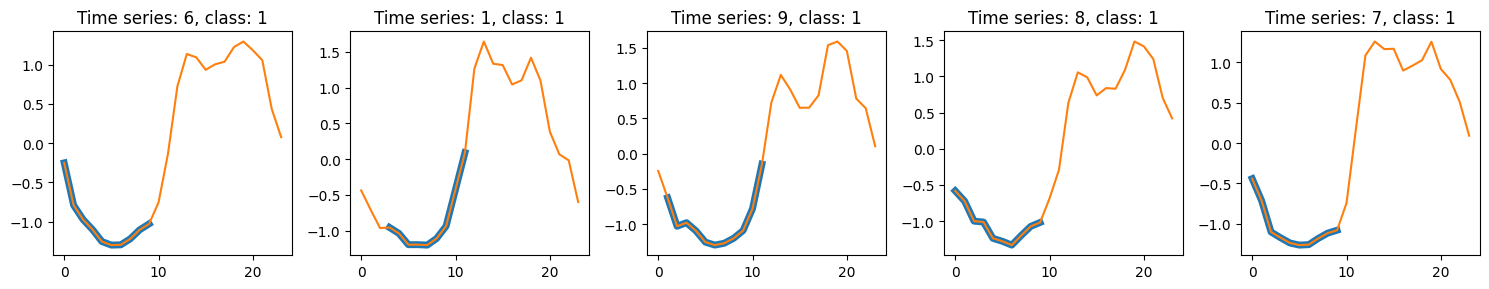

#10: Series ID: 10, start_pos: 2, length: 11, info_gain: 0.9980008838722996, 
#11: Series ID: 16, start_pos: 1, length: 15, info_gain: 0.9980008838722996, 
#12: Series ID: 12, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#13: Series ID: 13, start_pos: 2, length: 11, info_gain: 0.9980008838722996, 
#14: Series ID: 15, start_pos: 7, length: 8, info_gain: 0.9980008838722996, 


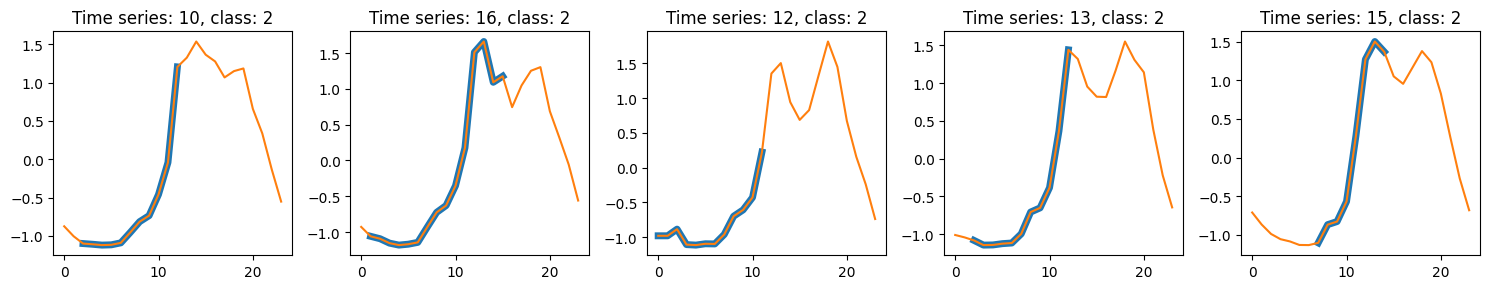

#15: Series ID: 11, start_pos: 2, length: 11, info_gain: 0.9980008838722996, 
#16: Series ID: 19, start_pos: 0, length: 15, info_gain: 0.9980008838722996, 
#17: Series ID: 17, start_pos: 0, length: 16, info_gain: 0.9980008838722996, 
#18: Series ID: 18, start_pos: 0, length: 17, info_gain: 0.9980008838722996, 
#19: Series ID: 14, start_pos: 0, length: 14, info_gain: 0.9980008838722996, 


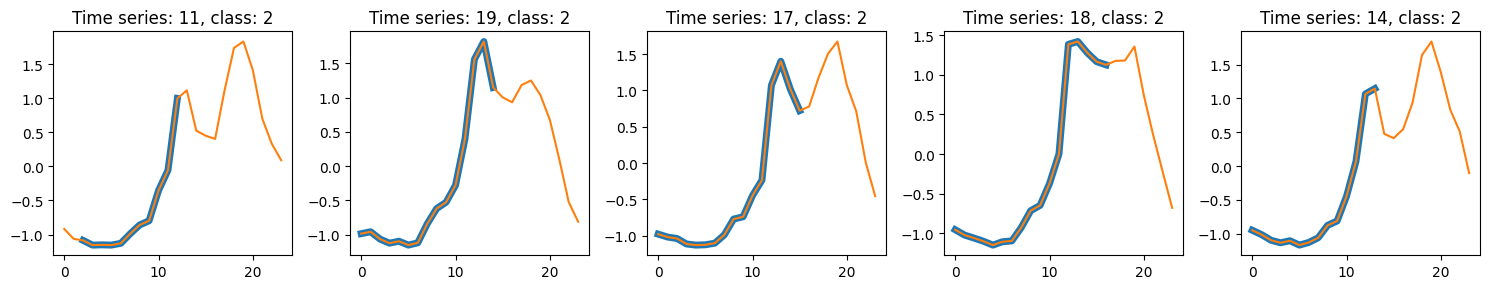

In [57]:
ncols = 5
for start in range(len(st.shapelets) // ncols):
    plot_shapelets(st, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname=f'images/chinatown-shapelets-{start}.jpg')

**Observation:** By using more than one instance by class, the model behaves like it is learning noisy versions of the same shaphelets

## OneShot ST

### OneShot ST 1:

Here, shapelets are selected using only the generators from KernelsGenerator  
The limitation of this approach is that the quality of a shapelet candidate is not computed on the whole training set, but only on the generators

In [58]:
# create the dataset to learn shapelet from
sast = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state)

sast.init_sast(X_train, y_train) 

y_resample = np.array(list(sast.kernels_generators_.keys()), dtype=np.int32)
X_resample = [t.squeeze() for _, t in sast.kernels_generators_.items()]
X_resample = np.array(X_resample, dtype=np.float32)
X_resample_sktime = from_2d_array_to_nested(pd.DataFrame(X_resample))

start = time.time()

ost1 = ShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf)

ost1.fit(X_resample_sktime, y_resample)

X_train_transformed = ost1.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost1.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)

Score: 0.44314868804664725
duration: 0.5616555213928223


for: 0
#0: Series ID: 0, start_pos: 0, length: 3, info_gain: 0, 
#1: Series ID: 1, start_pos: 0, length: 3, info_gain: 0, 


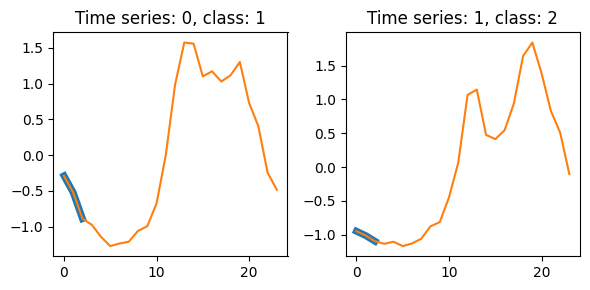

In [59]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    print ("for:",start)
    plot_shapelets(ost1, X_resample_sktime, y_resample, offset=start * ncols, nb_shapelet = ncols)

### OneShot ST 2:

Here we fix the limitation of the previous part by generating shapelet candidates from only `nb_inst_per_class` for each class, however the quality of each shapelet is computed over the whole training set

In [60]:
from sast.stck import ShapeletTransformK

NameError: name 'ContractedShapeletTransform' is not defined

In [61]:
start = time.time()

ost2 = ShapeletTransformK(min_shapelet_length=min_shp_length, 
                          max_shapelet_length=np.inf, 
                          nb_inst_per_class=nb_inst_per_class)
ost2.fit(X_train_sktime, y_train)

X_train_transformed = ost2.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost2.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost2.nb_inst_per_class)

NameError: name 'ShapeletTransformK' is not defined

In [62]:
ncols = 5 if len(ost2.shapelets) > 5 else len(ost2.shapelets)
for start in range(len(ost2.shapelets) // ncols):
    plot_shapelets(ost2, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-1ST.jpg')

NameError: name 'ost2' is not defined

In [63]:
start = time.time()

ost3 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=2)
ost3.fit(X_train_sktime, y_train)

X_train_transformed = ost3.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost3.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost3.nb_inst_per_class)

NameError: name 'OShapeletTransform' is not defined

#0: Series ID: 18, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#1: Series ID: 15, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 
#2: Series ID: 7, start_pos: 3, length: 10, info_gain: 0.9980008838722996, 
#3: Series ID: 11, start_pos: 0, length: 13, info_gain: 0.9980008838722996, 


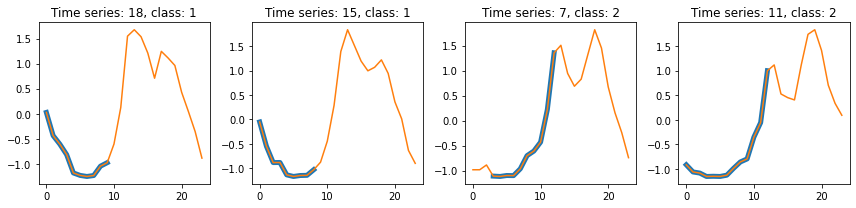

In [ ]:
ncols = 5 if len(ost3.shapelets) > 5 else len(ost3.shapelets)
for start in range(len(ost3.shapelets) // ncols):
    plot_shapelets(ost3, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-2ST.jpg')

In [ ]:
start = time.time()

ost4 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=3)
ost4.fit(X_train_sktime, y_train)

X_train_transformed = ost4.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost4.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost4.nb_inst_per_class)

NameError: name 'OShapeletTransform' is not defined

#0: Series ID: 14, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#1: Series ID: 5, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 


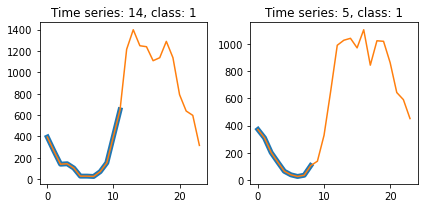

In [ ]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    plot_shapelets(ost4, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols)

## Using ROCKET:



In [ ]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.kernel_based import RocketClassifier


In [ ]:
X_train, y_train = load_UCR_UEA_dataset(name="Chinatown",extract_path='data', split="train")
X_test, y_test = load_UCR_UEA_dataset(name="Chinatown",extract_path='data', split="test")

In [ ]:
rocket= RocketClassifier(num_kernels=10_000)#proposed 10000 because it is more stable
rocket.fit(X_train,y_train)

RocketClassifier()

In [39]:
rocket.score(X_test,y_test)

0.9825072886297376